In [1]:
import numpy as np
import pylab
from tqdm.notebook import tqdm
import math
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
data = pd.read_csv('ceny_energii_pl.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data = data.squeeze()
data = data.iloc[2190:].resample('1D').first().ffill()

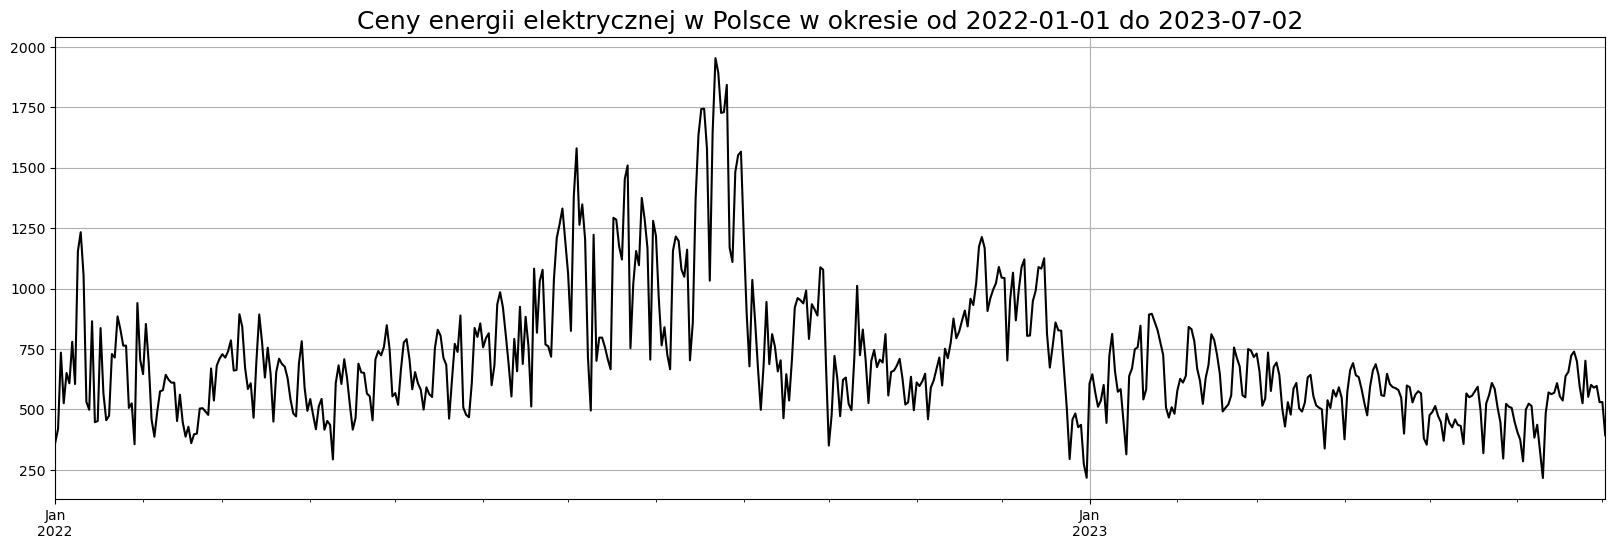

In [3]:
plt.rcParams["figure.figsize"] = (20,6)
data.plot(legend=False, color='black')
date_from = data.index[0].strftime('%Y-%m-%d')
date_to = data.index[-1].strftime('%Y-%m-%d')
plt.title(f'Ceny energii elektrycznej w Polsce w okresie od {date_from} do {date_to}', fontsize=18)
plt.xticks([datetime.strptime(f'{year}-01-01', '%Y-%m-%d') for year in [2022 + 1*i for i in range(2)]])
plt.xlabel('')
plt.grid()
plt.show()

In [74]:
class SDE:
    def __init__(self, drift, diffusion, data):
        """
        Args:
            drift (callable): Drift coefficient function.
            diffusion (callable): Diffusion coefficient function.
            data (pd.Series): Time series data used for the SDE.
        """
        self.drift = drift
        self.diffusion = diffusion
        self.data = data
        
        
    def estimate_parameters_mle(self, lb_drift, ub_drift, lb_diff, ub_diff):
        """
        Estimates parameters of stochastic differential equation
        dX_t = a(t, X_t)dt + b(t, X_t)dW_t, where:
        a - drift coefficient
        b - diffusion coefficient
        using maximum likelihood estimation (MLE) method.
        
        Args:
            lb_drift (float): Lower bound of the drift coefficient.
            ub_drift (float): Upper bound of the drift coefficient.
            lb_diff (float): Lower bound of the diffusion coefficient.
            ub_diff (float): Upper bound of the diffusion coefficient.

        """
        drift_sample = np.linspace(lb_drift, ub_drift, 500)[1:]
        diffusion_sample = np.linspace(lb_diff, ub_diff, 1500)[1:]
        x = self.data.values
        x_range = np.arange(0, len(x) - 1)
        drift, diffusion = np.meshgrid(drift_sample, diffusion_sample)
        f_res = self.drift(drift.ravel(), x[x_range][:, np.newaxis])
        g_res = self.diffusion(diffusion.ravel(), x[x_range][:, np.newaxis])
        mu = x[x_range] + f_res.T  
        sigma = g_res.T
        temp = -(x[x_range + 1] - mu) ** 2 / (2.0 * sigma**2) - np.log(np.sqrt(2.0 * np.pi * sigma**2))
        f_log = -np.sum(temp, axis=1)
        
        min_index = np.argmin(f_log)
        drift_min = drift.ravel()[min_index]
        diffusion_min = diffusion.ravel()[min_index]
        
        self.drift = (lambda f: lambda x: f(drift_min, x))(self.drift)
        self.diffusion = (lambda f: lambda x: f(diffusion_min, x))(self.diffusion)
        
        return drift_min, diffusion_min
    
    @staticmethod
    def Wiener(h, n):
        """
        Generates Wiener path.
        
        Args:
            h: step size
            n: number of steps
            
        Returns:
            Array representing the Wiener path.
        """
        w = np.zeros(n+1)
        for i in range(1, n+1):
            w[i] = w[i-1]+np.sqrt(h)*np.random.normal(0, 1)
        return w
    

    def Euler_Maruyama(self, num_simulations, plot=True):
        """
        Simulates the Euler-Maruyama method for a given stochastic differential equation (SDE).

        Args:
            num_simulations: Number of simulations to perform.
            plot: Whether to plot the simulation results. Defaults to True.

        Returns:
            DataFrame containing the simulated SDE paths with dates as the index.
        """
        # Define SDE coefficients
        start_date = datetime(2022, 1, 1)
        end_date = datetime(2023, 7, 2)
        dates = self.data.index

        n = (end_date - start_date).days + 1
        x0 = self.data.values[0]
        h = 1 / n
        x = np.zeros((num_simulations, n))
        x[:, 0] = x0

        # Euler-Maruyama method
        for i in range(num_simulations):
            w = self.Wiener(h, n)
            for j in range(1, n):
                dW = w[j] - w[j-1]
                x[i, j] = x[i, j-1] + self.drift(x[i, j-1]) * h + self.diffusion(x[i, j-1]) * dW

        df = pd.DataFrame(x.T, columns=[f'Simulation {i+1}' for i in range(num_simulations)])
        df['Date'] = dates
        df = df.set_index('Date')

        if plot:
            plt.figure(figsize=(10, 6))
            for i in range(num_simulations):
                plt.plot(df.index, df[f'Simulation {i+1}'])
            data.plot(color='black')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.title(f'{num_simulations} SDE simulations with real data')
            plt.xticks(rotation=45)
            plt.grid(True)
            plt.show()

        return df
    
    def goodness_of_fit_test(self, num_simulations, threshold, num_bins=30):
        """
        Performs the Chi-Square Goodness-of-Fit test using the Euler-Maruyama method.

        Args:
            num_simulations: Number of simulations to perform.
            threshold: Significance level for the chi-squared test.
            num_bins (optional): Number of bins for histogram calculation. Defaults to 30.

        Returns:
            Tuple containing the chi-squared statistic, p-value, and result of the goodness-of-fit test.
        """
        # Generate simulated data based on the SDE model
        simulated_data = self.Euler_Maruyama(num_simulations, False).mean(axis=1).values

        # Calculate observed and expected frequencies
        observed_freq, _ = np.histogram(self.data.values, bins=num_bins)
        expected_freq, _ = np.histogram(simulated_data, bins=num_bins)

        # Perform chi-squared test
        chi2_stat, p_value = chi2_contingency(np.array([observed_freq, expected_freq]))[:2]

        # Determine if the model has goodness-of-fit or lack-of-fit
        result = "Lack-of-fit" if p_value < threshold else "Goodness-of-fit"

        return chi2_stat, p_value, result

## Model Blacka-Scholesa

Równanie Blacka-Scholesa:

$dX(t) = \mu X(t) dt + \sigma X(t) d W_t$

$X(t)$ - cena akcji w t-tym momencie

$t\in [0;T]$, $\mu \in \mathbb{R}$ (współczynnik dryfu), $\sigma > 0$ (współczynnik dyfuzji)

$W_t$ - proces Wienera

Results from MLE:
  drift: 0.20040080160320642
  diffusion: 0.333555703802535


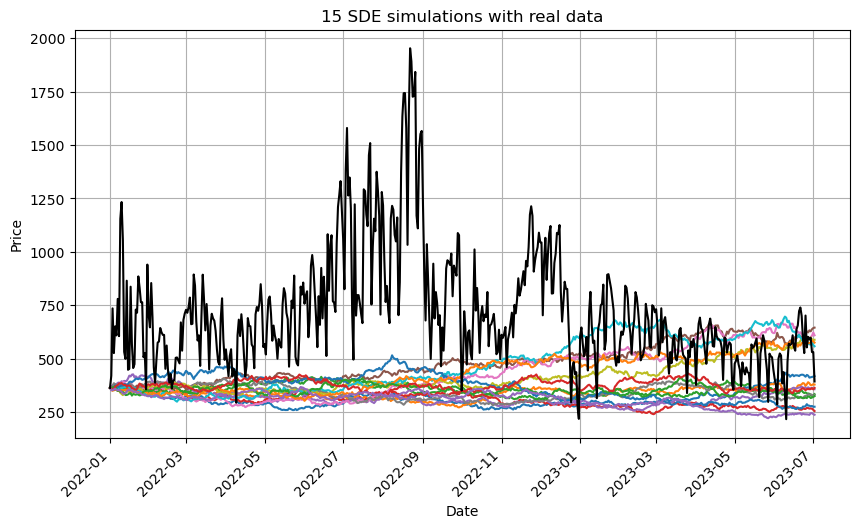

Results from Goodness-of-Fit test:
  Chi-square statistic: 322.90369943045346
  p-value: 2.318059671847923e-51
  Result: Lack-of-fit


In [79]:
drift = lambda mu, x: mu * x
diffusion = lambda sigma, x: sigma * x
sde = SDE(drift, diffusion, data)
drift_coef, diffusion_coef = sde.estimate_parameters_mle(0.0, 100.0, 0.0, 100.0)
print(f'Results from MLE:\n  drift: {drift_coef}\n  diffusion: {diffusion_coef}')
sde.Euler_Maruyama(15)
chi2_stat, p_value, result = sde.goodness_of_fit_test(1000, 0.05)
print(f'Results from Goodness-of-Fit test:\n  Chi-square statistic: {chi2_stat}\n  p-value: {p_value}\n  Result: {result}')

## Model Ornsteina-Uhlenbecka

Model jest postaci:
    
$dX(t) = -\mu X(t) dt + \sigma d W_t$

$X(t)$ - cena akcji w t-tym momencie

$t\in [0;T]$, $\mu \in \mathbb{R}$ (współczynnik dryfu), $\sigma > 0$ (współczynnik dyfuzji)

$W_t$ - proces Wienera

Results from MLE:
  drift: 0.024048096192384766
  diffusion: 167.56504336224148


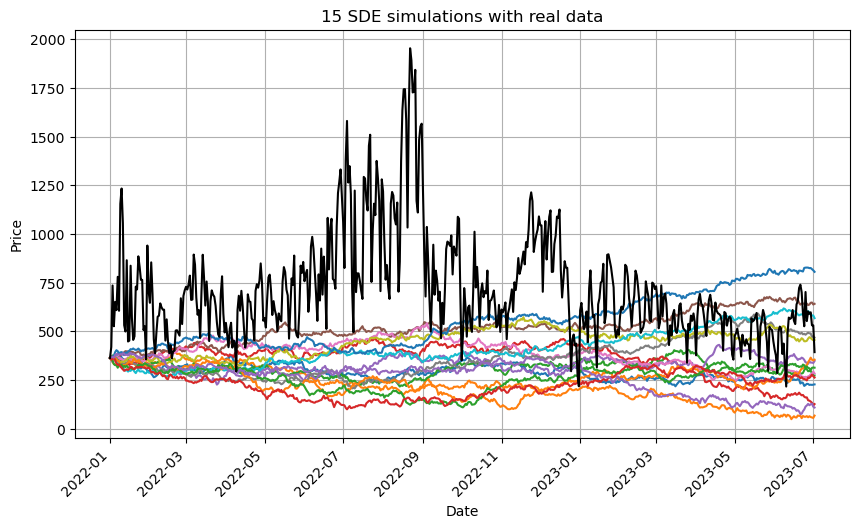

Results from Goodness-of-Fit test:
  Chi-square statistic: 440.93527822434277
  p-value: 3.557261599537541e-75
  Result: Lack-of-fit


In [78]:
drift = lambda mu, x: -mu * x
diffusion = lambda sigma, x: sigma * np.ones_like(x)
sde = SDE(drift, diffusion, data)
lb_drift = 0.0
ub_drift = 1.0
lb_diffusion = 20.0
ub_diffusion = 300.0
drift_coef, diffusion_coef = sde.estimate_parameters_mle(lb_drift, ub_drift, lb_diffusion, ub_diffusion)
print(f'Results from MLE:\n  drift: {drift_coef}\n  diffusion: {diffusion_coef}')
sde.Euler_Maruyama(15)
chi2_stat, p_value, result = sde.goodness_of_fit_test(1000, 0.05)
print(f'Results from Goodness-of-Fit test:\n  Chi-square statistic: {chi2_stat}\n  p-value: {p_value}\n  Result: {result}')

## Model CIR

Model jest postaci:
    
$dX(t) = a(b-X(t)) dt + \sigma \sqrt{X(t)}d W_t$

$X(t)$ - cena akcji w t-tym momencie

$t\in [0;T]$, $\mu \in \mathbb{R}$ (współczynnik dryfu), $\sigma > 0$ (współczynnik dyfuzji)

$W_t$ - proces Wienera

In [52]:
import numpy as np

def estimate_parameters_mle(f, g, x):
    theta_min = np.inf
    theta_range = np.linspace(0.0, 1.0, 500)[1:]
    x_range = np.arange(1, len(x) - 1)
    theta1, theta2 = np.meshgrid(theta_range, theta_range)

    f_res = f(theta1.ravel(), x[x_range][:, np.newaxis])
    g_res = g(theta2.ravel())

    mu = x[x_range] + f_res.reshape((-1, 1))
    sigma = g_res.reshape((-1, 1))

    temp = -(x[x_range + 1] - mu) ** 2 / (2.0 * sigma ** 2) - np.log(np.sqrt(2.0 * np.pi * sigma ** 2))
    f_log = -np.sum(temp, axis=1)

    min_index = np.argmin(f_log)
    theta1_min = theta1.ravel()[min_index]
    theta2_min = theta2.ravel()[min_index]
    f_min = f_log[min_index]

    print(f"Results from MLE:\ntheta1: {theta1_min}, theta2: {theta2_min}, f_min: {f_min}")

    return theta1_min, theta2_min

# Define the CIR model functions
f = lambda theta1, x: theta1 * (theta2 - x)
g = lambda theta2: theta2 * np.sqrt(x[x_range][:, np.newaxis])

# Example usage
x = data.values  # Example data

theta1, theta2 = estimate_parameters_mle(f, g, x)


NameError: name 'x_range' is not defined